In [11]:
import s3fs
import xarray as xr
import xesmf
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
fs = s3fs.S3FileSystem(anon=True) ### This is needed to be able to access wihtouth erroring
fmap = s3fs.S3Map('s3://era5-pds/zarr/2010/07/data/surface_air_pressure.zarr', s3=fs)
dset = xr.open_zarr(fmap, consolidated=True)
dset

<xarray.Dataset>
Dimensions:               (lat: 721, lon: 1440, time0: 744)
Coordinates:
  * lat                   (lat) float32 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * lon                   (lon) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time0                 (time0) datetime64[ns] 2010-07-01 ... 2010-07-31T23...
Data variables:
    surface_air_pressure  (time0, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

In [3]:
geogrid = xr.open_dataset('./geogrid-files/geo_em.d01.denver.noGlacier.nc')


In [62]:
dset_subset = dset.surface_air_pressure[:,196:208,1016:1028]
dset_subset

<xarray.DataArray 'surface_air_pressure' (time0: 744, lat: 12, lon: 12)>
dask.array<getitem, shape=(744, 12, 12), dtype=float32, chunksize=(372, 12, 12), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 41.0 40.75 40.5 40.25 40.0 ... 39.0 38.75 38.5 38.25
  * lon      (lon) float32 254.0 254.2 254.5 254.8 ... 256.0 256.2 256.5 256.8
  * time0    (time0) datetime64[ns] 2010-07-01 ... 2010-07-31T23:00:00
Attributes:
    long_name:       Surface pressure
    nameCDM:         Surface_pressure_surface
    nameECMWF:       Surface pressure
    product_type:    analysis
    shortNameECMWF:  sp
    standard_name:   surface_air_pressure
    units:           Pa

In [70]:
lonsv, latsv = np.meshgrid(-360+dset_subset.lon.values,dset_subset.lat.values)

dset_subset[0,:,:].values

# does_this_work = xr.DataArray(data=
#     {
#     'surface_air_pressure':dset_subset[0].values,
#     }
#     ,coords={
#         "lat": (["x","y"],latsv),
#         "lon": (["x","y"], lonsv),
#     }
# )   

does_this_work2 = xr.Dataset(
    {
    'surface_air_pressure':(["x","y"],dset_subset[1].values),
    }
    ,coords={
        "lat": (["x","y"],latsv),
        "lon": (["x","y"], lonsv),
    }
)   
does_this_work2

<xarray.Dataset>
Dimensions:               (x: 12, y: 12)
Coordinates:
    lat                   (x, y) float32 41.0 41.0 41.0 ... 38.25 38.25 38.25
    lon                   (x, y) float32 -106.0 -105.8 -105.5 ... -103.5 -103.2
Dimensions without coordinates: x, y
Data variables:
    surface_air_pressure  (x, y) float32 7.535e+04 7.582e+04 ... 8.726e+04

In [37]:
ds_out = xr.Dataset(
    {
        "lat": (["x","y"],geogrid.XLAT_M[0].values),
        "lon": (["x","y"], geogrid.XLONG_M[0].values),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (x: 129, y: 129)
Dimensions without coordinates: x, y
Data variables:
    lat      (x, y) float32 39.17 39.17 39.17 39.17 ... 40.32 40.32 40.32 40.32
    lon      (x, y) float32 -105.7 -105.7 -105.7 -105.7 ... -104.3 -104.3 -104.2

In [71]:
regridder = xesmf.Regridder(does_this_work2, ds_out, "bilinear")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_12x12_129x129.nc 
Reuse pre-computed weights? False 
Input grid shape:           (12, 12) 
Output grid shape:          (129, 129) 
Periodic in longitude?      False

In [72]:
dout = regridder(does_this_work2)

In [73]:
dout

<xarray.Dataset>
Dimensions:               (x: 129, y: 129)
Coordinates:
    lon                   (x, y) float32 -105.7 -105.7 -105.7 ... -104.3 -104.2
    lat                   (x, y) float32 39.17 39.17 39.17 ... 40.32 40.32 40.32
Dimensions without coordinates: x, y
Data variables:
    surface_air_pressure  (x, y) float32 7.231e+04 7.234e+04 ... 8.555e+04
Attributes:
    regrid_method:  bilinear

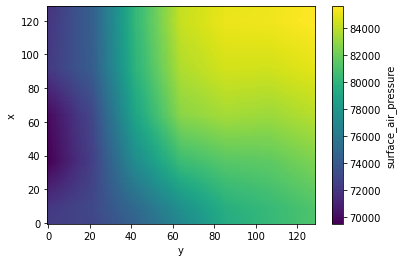

In [75]:
dout.surface_air_pressure.plot()